In [1]:
%%capture
!git clone https://github.com/giangbang/RL-final-project-AIT-3007
%cd RL-final-project-AIT-3007
!pip install -r requirements.txt

In [2]:
import torch
import torch.optim as optim
from torch import nn
import os
import numpy as np
import random
from collections import deque
from magent2.environments import battle_v4
import time
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
class FinalQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, index):
        return self.buffer[index]

class MyQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
        )

        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]

        self.fc = nn.Sequential(
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, action_shape)
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        out = self.cnn(x)

        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]

        out = out.reshape(batchsize, -1)
        return self.fc(out)

In [6]:


class Trainer:
    def __init__(self, env, input_shape=None, action_shape=None, learning_rate=1e-3):
        self.env = env
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.q_network =MyQNetwork(input_shape, action_shape).to(self.device)

        self.target_network = MyQNetwork(input_shape, action_shape).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.steplr = lr_scheduler.StepLR(optimizer=self.optimizer, step_size=1, gamma=0.9)
        self.replay_buffer = ReplayBuffer(capacity=60000)

        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.97
        self.update_target_every = 3

        self.episode_rewards = []
        self.episode_losses = []


    def select_action(self, observation, agent):
        # Nếu epsilon lớn hơn random, chọn hành động ngẫu nhiên
        if np.random.rand() <= self.epsilon:
            return self.env.action_space(agent).sample()
    
        observation = torch.FloatTensor(observation).unsqueeze(0).to(self.device)
    
        with torch.inference_mode():
            q_values = self.q_network(observation)
    
        # **Kết hợp:** Nếu cần thăm dò dựa trên softmax, tính xác suất từ Q-values
        if np.random.rand() <= self.epsilon * 0.1:  
            exp_q_values = torch.exp(q_values).cpu().numpy().flatten()
            action_probabilities = exp_q_values / exp_q_values.sum()  # Chuẩn hóa
            return np.random.choice(len(action_probabilities), p=action_probabilities)
    
        return torch.argmax(q_values, dim=1).item()

    def training(self, episodes=100, batch_size=1024):
        for episode in range(episodes):
            self.env.reset()
            total_reward = 0
            reward_for_agent = {agent: 0 for agent in self.env.agents if agent.startswith('blue')}
            prev_observation = {}
            prev_action = {}
            step = 0

            for idx, agent in enumerate(self.env.agent_iter()):
                step += 1
                observation, reward, termination, truncation, info = self.env.last()
                observation = np.transpose(observation, (2, 0, 1))

                agent_handle = agent.split('_')[0]

                if agent_handle == 'blue':
                    total_reward += reward
                    reward_for_agent[agent] += reward

                if termination or truncation:
                    action = None
                else:
                    if agent_handle == 'blue':
                        action = self.select_action(observation, agent)  
                    else:
                        action = self.env.action_space(agent).sample()

                if agent_handle == 'blue':
                    if agent in prev_observation and agent in prev_action:
                        self.replay_buffer.add(
                            prev_observation[agent],
                            prev_action[agent],
                            reward,
                            observation,
                            termination
                        )

                    prev_observation[agent] = observation
                    prev_action[agent] = action

                self.env.step(action)

            # Nếu replay buffer đủ dữ liệu, tiến hành huấn luyện
            if len(self.replay_buffer) >= batch_size:
                dataloader = DataLoader(self.replay_buffer, batch_size=batch_size, shuffle=True, drop_last=True)
                loss = self.update_model(dataloader)
                episode_loss = loss

            # Cập nhật mạng mục tiêu định kỳ
            if (episode + 1) % self.update_target_every == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
                self.steplr.step()

            max_reward = max(reward_for_agent.values())

            print(f"Episode {episode + 1}, Epsilon: {self.epsilon:.2f}, Total Reward: {total_reward}, Steps: {step}, Max Reward: {max_reward}, lr: {self.steplr.get_last_lr()}")

            # Giảm epsilon để giảm dần khả năng thăm dò
            self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

            self.episode_rewards.append(total_reward)
            self.episode_losses.append(episode_loss)

        # Plot the rewards after all episodes
        self.plot_rewards_and_losses()

    def update_model(self, dataloader):
        self.q_network.train()
        total_loss = 0
        for states, actions, rewards, next_states, dones in dataloader:
            # Chuyển tensor sang thiết bị
            states = states.to(dtype=torch.float32, device=self.device)
            actions = actions.to(dtype=torch.long, device=self.device)
            rewards = rewards.to(dtype=torch.float32, device=self.device)
            next_states = next_states.to(dtype=torch.float32, device=self.device)
            dones = dones.to(dtype=torch.float32, device=self.device)

            # Giá trị Q hiện tại
            current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            # Giá trị Q mục tiêu với Double Q-Learning
            with torch.inference_mode():
                next_actions = self.q_network(next_states).argmax(1)
                next_q_values = self.target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)

            # Tính giá trị Q mong đợi
            expected_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

            # Tính loss và cập nhật mô hình
            loss = self.criterion(current_q_values, expected_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        # Return the average loss for this batch
        return total_loss / len(dataloader)

    def plot_rewards_and_losses(self):
        # Create a plot with two y-axes for reward and loss
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot rewards
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward', color='tab:blue')
        ax1.plot(range(1, len(self.episode_rewards) + 1), self.episode_rewards, color='tab:blue', label='Reward')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create a second y-axis for the loss
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Loss', color='tab:red')
        ax2.plot(range(1, len(self.episode_losses) + 1), self.episode_losses, color='tab:red', label='Loss')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Title and grid
        plt.title('Reward and Loss per Episode')
        plt.grid(True)
        plt.show()

In [7]:
from torch.utils.data import Dataset, DataLoader

Episode 1, Epsilon: 1.00, Total Reward: -3278.400119997561, Steps: 159856, Max Reward: -35.00000145845115, lr: [0.001]
Episode 2, Epsilon: 0.97, Total Reward: -3181.3501157546416, Steps: 160552, Max Reward: -13.345000499859452, lr: [0.001]
Episode 3, Epsilon: 0.94, Total Reward: -3097.9701121784747, Steps: 158749, Max Reward: -3.6550001241266727, lr: [0.0009000000000000001]
Episode 4, Epsilon: 0.91, Total Reward: -3061.5001103086397, Steps: 160049, Max Reward: -31.000001387670636, lr: [0.0009000000000000001]
Episode 5, Epsilon: 0.89, Total Reward: -2948.795106343925, Steps: 155851, Max Reward: -5.140000205487013, lr: [0.0009000000000000001]
Episode 6, Epsilon: 0.86, Total Reward: -2880.2801025398076, Steps: 156160, Max Reward: -4.450000163167715, lr: [0.0008100000000000001]
Episode 7, Epsilon: 0.83, Total Reward: -2573.260094271973, Steps: 149636, Max Reward: -2.2550000976771116, lr: [0.0008100000000000001]
Episode 8, Epsilon: 0.81, Total Reward: -2683.1150956600904, Steps: 154669, Max

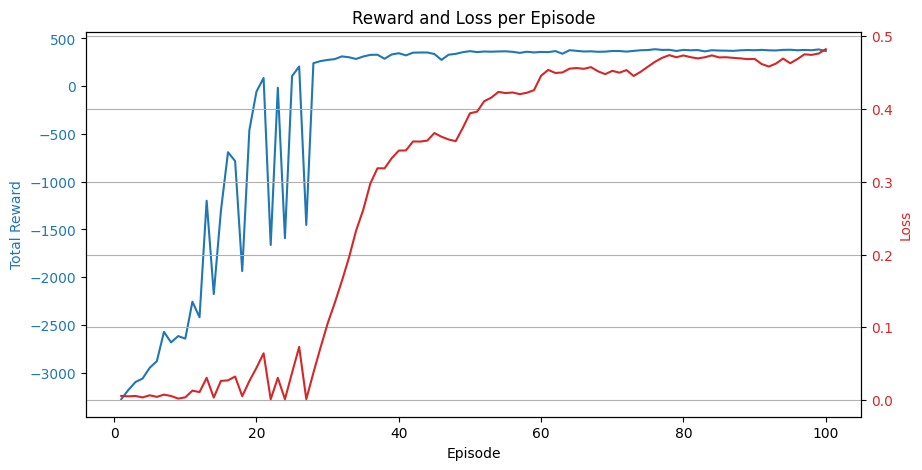

In [8]:
env = battle_v4.env(map_size=45, render_mode=None)

trainer = Trainer(env, input_shape=env.observation_space("red_0").shape, action_shape=env.action_space("red_0").n)
trainer.training()

In [9]:
torch.save(trainer.q_network.state_dict(), "final_blue.pt")
print("Training complete. Model saved.")

Training complete. Model saved.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
from magent2.environments import battle_v4
import torch
import numpy as np

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, *args, **kwargs: x  # Fallback: tqdm becomes a no-op


def eval():
    max_cycles = 300
    env = battle_v4.env(map_size=45, max_cycles=max_cycles)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    def random_policy(env, agent, obs):
        return env.action_space(agent).sample()

    q_network = QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    q_network.load_state_dict(
        torch.load("/kaggle/working/RL-final-project-AIT-3007/red.pt", weights_only=True, map_location="cpu")
    )
    q_network.to(device)

    final_q_network = FinalQNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    final_q_network.load_state_dict(
        torch.load("/kaggle/working/RL-final-project-AIT-3007/red_final.pt", weights_only=True, map_location="cpu")
    )
    final_q_network.to(device)

    my_network = MyQNetwork(
        env.observation_space("blue_0").shape, env.action_space("blue_0").n
    )
    my_network.load_state_dict(
        torch.load("/kaggle/working/RL-final-project-AIT-3007/final_blue.pt", weights_only=True, map_location="cpu")
    )
    my_network.to(device)

    def pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def final_pretrain_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = final_q_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def my_policy(env, agent, obs):
        observation = (
            torch.Tensor(obs).float().permute([2, 0, 1]).unsqueeze(0).to(device)
        )
        with torch.no_grad():
            q_values = my_network(observation)
        return torch.argmax(q_values, dim=1).cpu().numpy()[0]

    def run_eval(env, red_policy, blue_policy, n_episode: int = 100):
        red_win, blue_win = [], []
        red_tot_rw, blue_tot_rw = [], []
        n_agent_each_team = len(env.env.action_spaces) // 2

        for _ in tqdm(range(n_episode)):
            env.reset()
            n_kill = {"red": 0, "blue": 0}
            red_reward, blue_reward = 0, 0

            for agent in env.agent_iter():
                observation, reward, termination, truncation, info = env.last()
                agent_team = agent.split("_")[0]

                n_kill[agent_team] += (
                    reward > 4.5
                )  # This assumes default reward settups
                if agent_team == "red":
                    red_reward += reward
                else:
                    blue_reward += reward

                if termination or truncation:
                    action = None  # this agent has died
                else:
                    if agent_team == "red":
                        action = red_policy(env, agent, observation)
                    else:
                        action = blue_policy(env, agent, observation)

                env.step(action)

            who_wins = "red" if n_kill["red"] >= n_kill["blue"] + 5 else "draw"
            who_wins = "blue" if n_kill["red"] + 5 <= n_kill["blue"] else who_wins
            red_win.append(who_wins == "red")
            blue_win.append(who_wins == "blue")

            red_tot_rw.append(red_reward / n_agent_each_team)
            blue_tot_rw.append(blue_reward / n_agent_each_team)

        return {
            "winrate_red": np.mean(red_win),
            "winrate_blue": np.mean(blue_win),
            "average_rewards_red": np.mean(red_tot_rw),
            "average_rewards_blue": np.mean(blue_tot_rw),
        }

    print("=" * 20)
    print("Eval with random policy")
    print(
        run_eval(
            env=env, red_policy=random_policy, blue_policy=my_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with trained policy")
    print(
        run_eval(
            env=env, red_policy=pretrain_policy, blue_policy=my_policy, n_episode=30
        )
    )
    print("=" * 20)

    print("Eval with final trained policy")
    print(
        run_eval(
            env=env,
            red_policy=final_pretrain_policy,
            blue_policy=my_policy,
            n_episode=30,
        )
    )
    print("=" * 20)


if __name__ == "__main__":
    eval()

/usr/local/lib/python3.10/dist-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(


Eval with random policy


100%|██████████| 30/30 [01:01<00:00,  2.04s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': -1.014483575366146, 'average_rewards_blue': 4.854020541905208}
Eval with trained policy


100%|██████████| 30/30 [01:15<00:00,  2.51s/it]


{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 0.7871769485090679, 'average_rewards_blue': 4.939761284949572}
Eval with final trained policy


100%|██████████| 30/30 [01:45<00:00,  3.50s/it]

{'winrate_red': 0.0, 'winrate_blue': 1.0, 'average_rewards_red': 1.7398909317777942, 'average_rewards_blue': 4.758516428382769}


In [11]:
from magent2.environments import battle_v4
import os
import cv2

import torch

if __name__ == "__main__":
    env = battle_v4.env(map_size=45, render_mode="rgb_array")
    vid_dir = "video"
    os.makedirs(vid_dir, exist_ok=True)
    fps = 60
    frames = []

    q_network_2 = MyQNetwork(
        env.observation_space("blue_0").shape, env.action_space("blue_0").n
    )
    q_network_2.load_state_dict(
        torch.load("/kaggle/working/RL-final-project-AIT-3007/final_blue.pt", weights_only=True, map_location="cpu")
    )

    # random policies
    env.reset()
    for agent in env.agent_iter():
        observation, reward, termination, truncation, info = env.last()

        if termination or truncation:
            action = None  # this agent has died
        else:
            agent_handle = agent.split("_")[0]
            if agent_handle == "blue":
                observation = (
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0)
                )
                with torch.no_grad():
                    q_values = q_network_2(observation)
                action = torch.argmax(q_values, dim=1).numpy()[0]
            else:
                action = env.action_space(agent).sample()


        env.step(action)

        if agent == "red_0":
            frames.append(env.render())

    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, f"random.mp4"),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    print("Done recording random agents")

    # pretrained policies
    frames = []
    env.reset()


    q_network = QNetwork(
        env.observation_space("red_0").shape, env.action_space("red_0").n
    )
    q_network.load_state_dict(
        torch.load("red.pt", weights_only=True, map_location="cpu")
    )
    for agent in env.agent_iter():

        observation, reward, termination, truncation, info = env.last()

        if termination or truncation:
            action = None  # this agent has died
        else:
            agent_handle = agent.split("_")[0]
            if agent_handle == "red":
                observation = (
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0)
                )
                with torch.no_grad():
                    q_values = q_network(observation)
                action = torch.argmax(q_values, dim=1).numpy()[0]
            else:
                observation = (
                    torch.Tensor(observation).float().permute([2, 0, 1]).unsqueeze(0)
                )
                with torch.no_grad():
                    q_values = q_network_2(observation)
                action = torch.argmax(q_values, dim=1).numpy()[0]

        env.step(action)

        if agent == "red_0":
            frames.append(env.render())

    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, f"pretrained.mp4"),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()
    print("Done recording pretrained agents")

    env.close()


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

Done recording random agents
Done recording pretrained agents
